# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [4]:
import math


p_k1 = 8 / 10
p_k2 = 2 / 10


entropy = -(p_k1 * math.log(p_k1) + p_k2 * math.log(p_k2))


entropy_rounded = round(entropy, 2)

print(f'Энтропия распределения классов: {entropy_rounded}')

Энтропия распределения классов: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [5]:


p_k1 = 8 / 10
p_k2 = 2 / 10



Q = p_k1*(1-p_k1)+p_k2*(1-p_k2)-p_k1 *(1*(1-1) + 0*(1-0)) - p_k2 * (1*(1-1) + 0*(1-0))

print(f'Критерий информативности распределения классов: {Q}')

Критерий информативности распределения классов: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
pred = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(f'Предсказание равно = {np.sum(pred)/len(pred)}')

Предсказание равно = 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [7]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [8]:
import numpy as np
import pandas as pd
from typing import Union, Tuple


def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector_sorted = sorted(feature_vector)
    full_vector = np.column_stack((feature_vector, target_vector))
    unique_values = np.unique(feature_vector_sorted)
    full_vector = full_vector[full_vector[:, 0].argsort()]
    threshold_best, gini_best = 0, float('-inf')
    ginis = []
    if feature_type == 'categorical':
      thresholds = np.unique(feature_vector)
      for threshold in thresholds:
        left_child = full_vector[full_vector[:, 0] <= threshold]
        right_child = full_vector[full_vector[:, 0] > threshold]

        n_l = len(left_child)
        n_r = len(right_child)
        n = n_l + n_r

        if task == 'classification':
          left_unique = np.unique(left_child)
          right_unique = np.unique(right_child)
          parent_unique = np.unique(full_vector)

          entropy_left = np.sum((n_l)/n * (left_unique/n_l) * (1 -  (left_unique/n_l)))
          entropy_right = np.sum((n_r)/n * (right_unique/n_r) * (1 -  (right_unique/n_r)))
          entropy_parent = np.sum((parent_unique/n) * (1 -  (parent_unique/n)))

          gain = entropy_parent - entropy_left - entropy_right
          ginis.append(gain)

          if gain > gini_best:
            gini_best = gain
            threshold_best = threshold
        elif task == 'regression':
          mse_left = (n_l/n)*(np.sum((left_child - np.mean(left_child))**2)/n_l)
          mse_right = (n_r/n)*(np.sum((right_child - np.mean(right_child))**2)/n_r)
          mse_parent = np.sum((full_vector - np.mean(full_vector))**2)/n

          gain = mse_parent - mse_left - mse_right
          ginis.append(gain)


          if gain > gini_best:
            gini_best = gain
            threshold_best = threshold


    if feature_type == 'real':
      thresholds = (unique_values[:-1] + unique_values[1:]) / 2
      for threshold in thresholds:
        left_child = full_vector[full_vector[:, 0] <= threshold]
        right_child = full_vector[full_vector[:, 0] > threshold]

        n_l = len(left_child)
        n_r = len(right_child)
        n = n_l + n_r

        if task == 'classification':
          left_unique = np.unique(left_child)
          right_unique = np.unique(right_child)
          parent_unique = np.unique(full_vector)

          entropy_left = np.sum((n_l)/n * (left_unique/n_l) * (1 -  (left_unique/n_l)))
          entropy_right = np.sum((n_r)/n * (right_unique/n_r) * (1 -  (right_unique/n_r)))
          entropy_parent = np.sum((parent_unique/n) * (1 -  (parent_unique/n)))

          gain = entropy_parent - entropy_left - entropy_right
          ginis.append(gain)

          if gain > gini_best:
            gini_best = gain
            threshold_best = threshold


        elif task == 'regression':

          mse_left = (n_l/n)*(np.sum((left_child - np.mean(left_child))**2)/n_l)
          mse_right = (n_r/n)*(np.sum((right_child - np.mean(right_child))**2)/n_r)
          mse_parent = np.sum((full_vector - np.mean(full_vector))**2)/n

          gain = mse_parent - mse_left - mse_right
          ginis.append(gain)


          if gain > gini_best:
            gini_best = gain
            threshold_best = threshold

    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [9]:
from sklearn.datasets import fetch_california_housing

In [10]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [12]:
thresholds, ginis, threshold_best, gini_best = find_best_split(X['MedInc'], y, task='regression', feature_type = 'real')

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

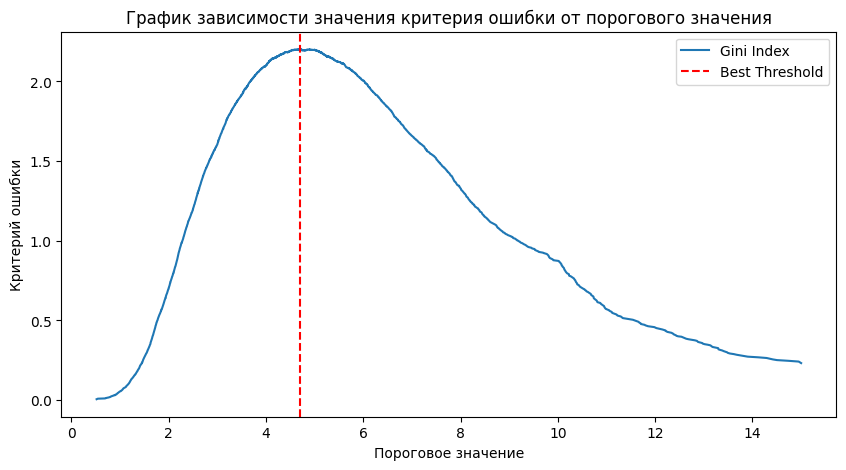

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, ginis, label='Gini Index')
plt.axvline(x=threshold_best, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Пороговое значение')
plt.ylabel('Критерий ошибки')
plt.title('График зависимости значения критерия ошибки от порогового значения')
plt.legend()
plt.show()

In [14]:
threshold_best

4.69045

In [15]:
gini_best

2.2023705877065947

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [16]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [17]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
            """
            Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
            предиката на объекте. Листовая вершина возвращает предсказание.
            :param x: np.array, элемент выборки
            :param node: dict, вершина дерева
            """
            if node["type"] == "terminal":
                return node["class"]

            feature_split = node["feature_split"]

            if feature_split in self._feature_types and self._feature_types[feature_split] == "categorical":
                category_split = node["category_split"]
                if x[feature_split] in category_split:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])

            elif self._feature_types[feature_split] == "real":
                threshold = node["threshold"]
                if x[feature_split] <= threshold:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])




    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [20]:
data = pd.read_csv('students.csv')
data = data.drop(columns = ['Unnamed: 0'], axis=1)
X = data[data.columns[:-1]]
y = data[data.columns[-1]]
X

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58
254,0.78,0.61,0.71,0.19,0.60
255,0.54,0.82,0.71,0.29,0.77
256,0.50,0.75,0.81,0.61,0.26


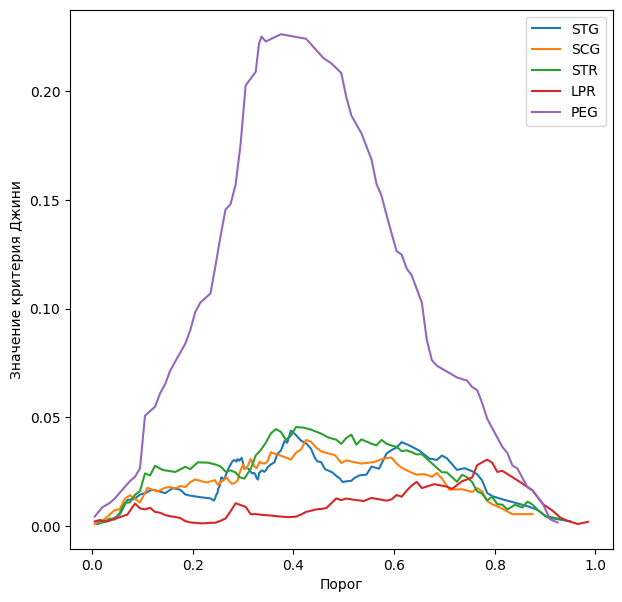

In [21]:
thresholds = []
gini_values = []
for feature in X.columns:
    threshold, ginis, threshold_best, gini_best = find_best_split(X[feature], y, task='regression', feature_type = 'real')
    thresholds.append(threshold)
    gini_values.append(ginis)
fig, ax = plt.subplots(figsize = (7, 7))
for i in range(5):
    ax.plot(thresholds[i], gini_values[i], label=X.columns[i])
ax.set_xlabel('Порог')
ax.set_ylabel('Значение критерия Джини')
ax.legend()
plt.show()


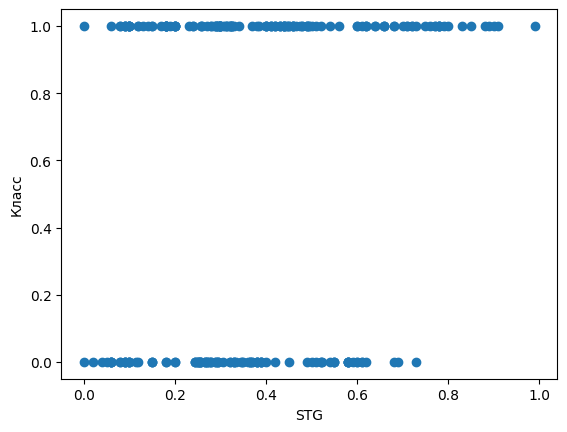

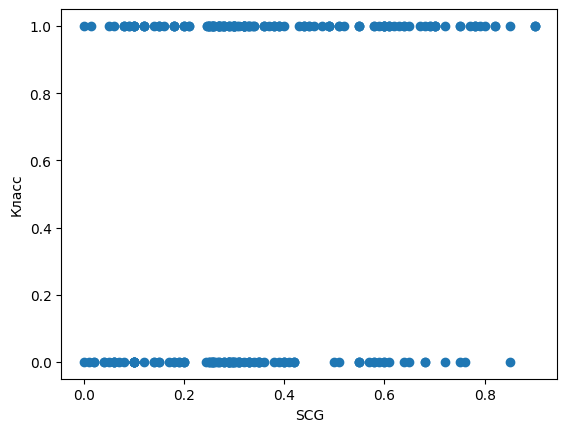

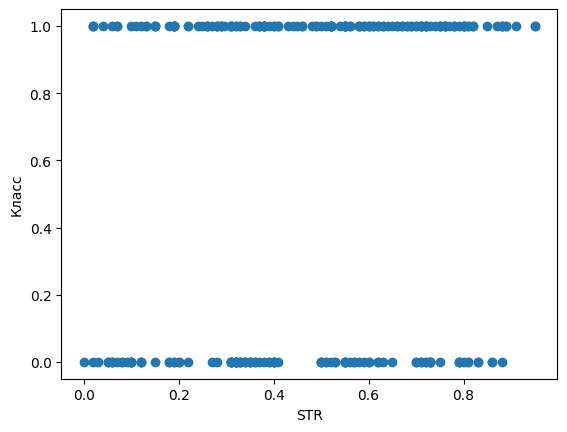

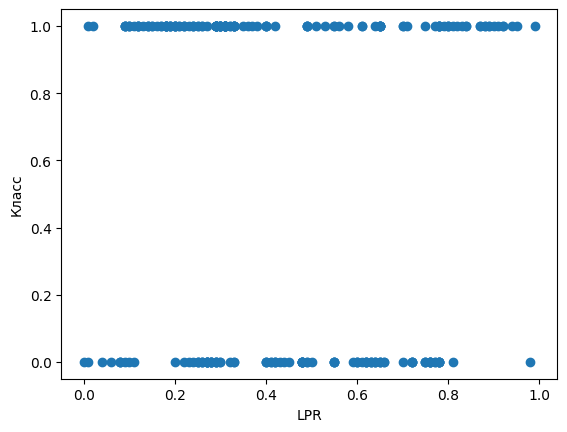

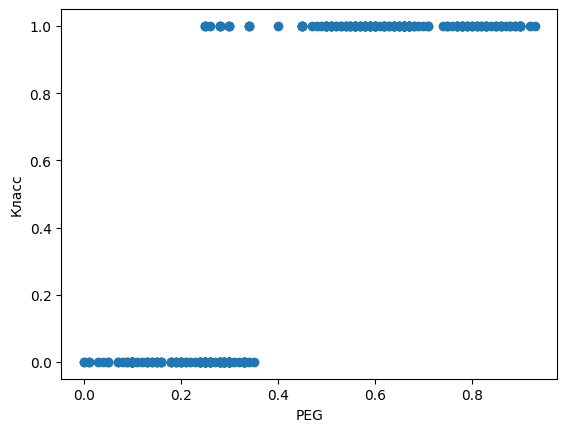

In [22]:
for i in enumerate(X.columns):
    plt.scatter(X[i[1]].values, y)
    plt.xlabel(i[1])
    plt.ylabel('Класс')
    plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?



---

Исходя из полученного графика, можно говорить о том, что деление выборки скорее всего стоит проводить по признаку 'LPR', так как значения критерия Джинни на этом признаке визуально меньше остальных признаков.

Графики рассеяния подтверждают сказанное выше. Мы видим, что на любом промежутке значения порога у нас нет высокой неопределенности в ответе, поскольку точек, принадлежащих классу "1" намного больше, чем точек класса "0".

Кривая для "хороших" признаков проходит как можно ниже, если смотреть по Оси Y и колеблется в определенном интервале.

Кривая для признаков, по которым деление практически невозможно, будет стремится к случайному значению критерия Джинни отличного от нуля.

---



**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [23]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data


--2024-05-25 18:22:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘agaricus-lepiota.data’

agaricus-lepiota.da     [  <=>               ] 364.95K  1.09MB/s    in 0.3s    

2024-05-25 18:22:30 (1.09 MB/s) - ‘agaricus-lepiota.data’ saved [373704]



In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [25]:
data = pd.read_csv('agaricus-lepiota.data')
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform)

In [26]:
data

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [27]:
X = data[data.columns[1:]]
y = data[data.columns[0]]
y

0       0
1       0
2       1
3       0
4       0
       ..
8118    0
8119    0
8120    0
8121    1
8122    0
Name: p, Length: 8123, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train

,x,s,n,t,p.1,f,c,n.1,k,e,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
4634,5,3,9,0,2,1,0,0,7,0,...,1,0,6,0,2,1,2,1,5,0
6652,5,3,2,0,2,1,0,1,0,1,...,2,6,7,0,2,1,0,7,4,2
6140,2,3,2,0,8,1,0,1,0,1,...,2,6,7,0,2,1,0,7,4,2
7151,5,2,2,0,7,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,0
438,5,3,4,1,0,1,0,0,7,0,...,3,7,7,0,2,1,4,3,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,5,3,4,0,2,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,0
5390,2,2,8,1,2,1,0,0,7,1,...,0,7,7,0,2,1,4,1,4,1
860,5,2,9,1,0,1,0,0,10,0,...,2,7,7,0,2,1,4,3,3,1
7603,3,0,3,0,5,1,1,0,7,0,...,1,7,7,0,2,2,4,7,3,1


In [30]:
feature_ = ['real']*X_train.shape[1]
tree = DecisionTree(feature_)
tree.fit(X_train.to_numpy(dtype='int64'), y_train.to_numpy(dtype='int64'))

In [31]:
y_test

1971    1
4661    0
5444    1
6526    1
5876    1
       ..
6870    1
1149    0
4998    1
3034    0
3340    1
Name: p, Length: 1625, dtype: int64

In [32]:
from sklearn.metrics import classification_report

In [33]:
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

IndexError: string index out of range

In [ ]:
len(y_pred)

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [35]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [37]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

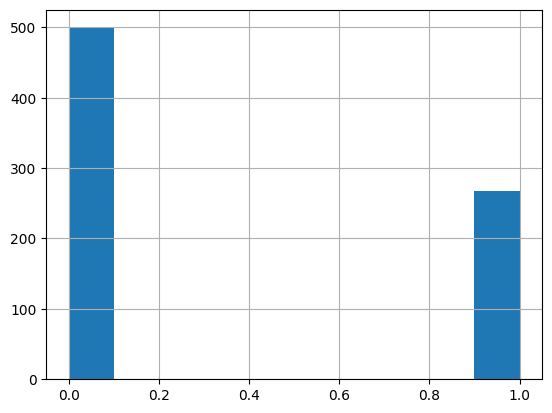

In [38]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [39]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print("Размеры обучающей-обучающей выборки:", X_train_train.shape, y_train_train.shape)
print("Размеры обучающей-валидационной выборки:", X_train_val.shape, y_train_val.shape)
print("Размеры тестовой выборки:", X_test.shape, y_test.shape)

Размеры обучающей-обучающей выборки: (375, 8) (375,)
Размеры обучающей-валидационной выборки: (162, 8) (162,)
Размеры тестовой выборки: (231, 8) (231,)


In [41]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
334,1,95,60,18,58,23.9,0.260,22
139,5,105,72,29,325,36.9,0.159,28
485,0,135,68,42,250,42.3,0.365,24
547,4,131,68,21,166,33.1,0.160,28
18,1,103,30,38,83,43.3,0.183,33
...,...,...,...,...,...,...,...,...
71,5,139,64,35,140,28.6,0.411,26
106,1,96,122,0,0,22.4,0.207,27
270,10,101,86,37,0,45.6,1.136,38
435,0,141,0,0,0,42.4,0.205,29


In [42]:
y_train

334    0
139    0
485    1
547    0
18     0
      ..
71     0
106    0
270    1
435    1
102    0
Name: Outcome, Length: 537, dtype: int64

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [43]:
max_depths = np.random.randint(4, 6, 10)
min_samples_leafs = np.random.randint(5, 7, 10)

In [44]:
max_depth = 0
min_samples_leaf = 0
best_score = 0
for depth in max_depths:
  for leaf in min_samples_leafs:
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
    clf.fit(X_train_train, y_train_train)

    score = f1_score(clf.predict(X_train_val), y_train_val)

    if score > best_score:
      max_depth = depth
      min_samples_leaf = leaf
      best_score = score
print(max_depth, min_samples_leaf)

5 6


In [45]:
clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=6)

In [46]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       151
           1       0.67      0.57      0.62        80

    accuracy                           0.75       231
   macro avg       0.73      0.71      0.72       231
weighted avg       0.75      0.75      0.75       231



In [47]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

In [48]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC ROC:", auc_roc)

Accuracy: 0.7532467532467533
Precision: 0.6666666666666666
Recall: 0.575
AUC ROC: 0.711341059602649


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [49]:
from sklearn.ensemble import BaggingClassifier

In [50]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf),n_estimators=50)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=6),
                  n_estimators=50)

In [51]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       151
           1       0.65      0.68      0.66        80

    accuracy                           0.76       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



In [52]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

In [53]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC ROC:", auc_roc)

Accuracy: 0.7619047619047619
Precision: 0.6506024096385542
Recall: 0.675
AUC ROC: 0.7414735099337748


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [55]:
grid_space={'max_depth':[3,5,10,12],
              'min_samples_split':[1,5,3, 10, 11,4]
           }

In [56]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(rf,param_grid=grid_space,cv=5,scoring='f1')
model_grid = grid.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

In [57]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'max_depth': 10, 'min_samples_split': 4}
Best score is: 0.6486362241300652


In [58]:
model_grid.best_params_['max_depth']

10

In [59]:
rf = RandomForestClassifier(max_depth=model_grid.best_params_['max_depth'], min_samples_split=model_grid.best_params_['min_samples_split'], n_estimators=50)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=50)

In [60]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       151
           1       0.63      0.65      0.64        80

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.75      0.74      0.75       231



In [61]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

In [62]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC ROC:", auc_roc)

Accuracy: 0.7445887445887446
Precision: 0.6265060240963856
Recall: 0.65
AUC ROC: 0.7223509933774834




---

Лучше всех показал Рандомный лес. Accuracy показывает 0.76

---



**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

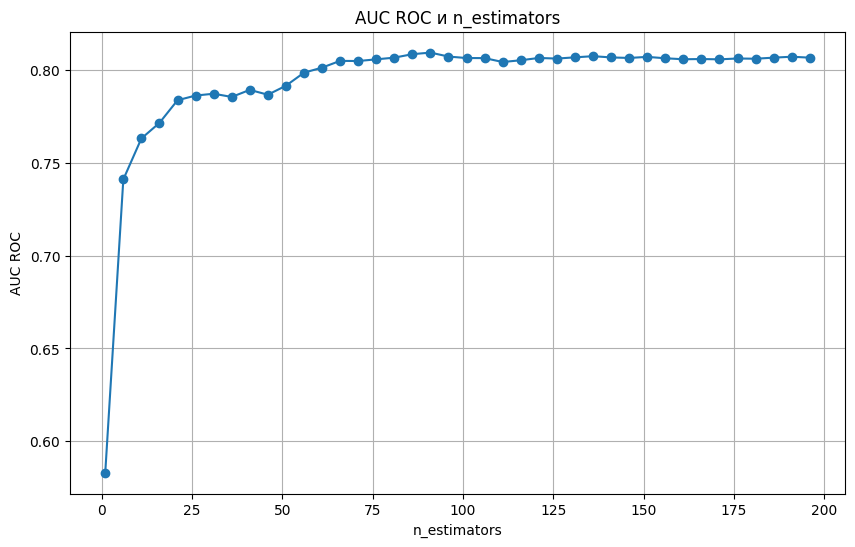

In [65]:
estimators_range = range(1, 200, 5)
listt = []
auc_roc_list = []

for estimators in estimators_range:
    model = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    listt.append(estimators)
    auc_roc_list.append(auc_roc)

plt.figure(figsize=(10, 6))
plt.plot(listt, auc_roc_list, marker='o', linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('AUC ROC')
plt.title('AUC ROC и n_estimators')
plt.grid(True)
plt.show()




---

Можно сделать вывод, что самое большое значение AUC ROC при n_estimators=600. Мы получили график, который указывает на то, что нет смысла использовать большое число деревьев, поскольку качество модели от этого сильно не улучшится.

---



**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

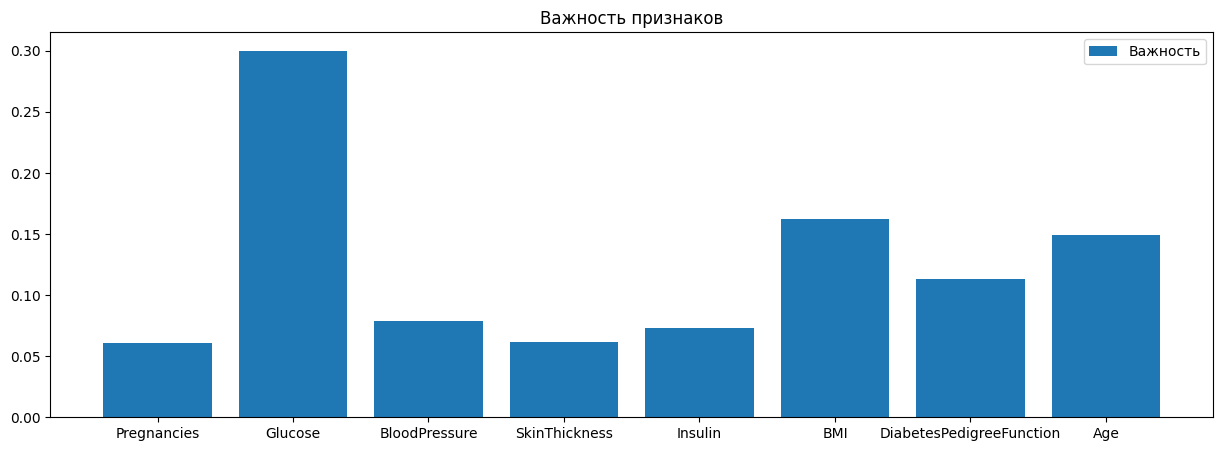

In [64]:
importance = rf.feature_importances_
features = X.columns


plt.figure(figsize=(15, 5))
plt.bar(features, importance, label='Важность')
plt.title('Важность признаков')
plt.legend()
plt.show()



---

Самым важным признаком для определения диабета оказалась "Глюкоза".

---

